## Строим и обучаем модель для чат бота

### Выгрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

c:\Users\huawei\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\huawei\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.17) or chardet (5.2.0)/charset_normalizer (2.0.0) doesn't match a supported version!
  warnings.warn(


### Загрузка данных из файла 'dialog.txt' в DataFrame df и вывод размера

In [2]:
df=pd.read_csv('dialog.txt',sep='\t',names=['Пользователь','Чат'])
print(f'Размер датафрейма: {len(df)}')
df

Размер датафрейма: 100


Пользователь  \
0                             Как открыть счет в ВТБ?   
1        Могу ли я открыть сберегательный счет в ВТБ?   
2       Какие документы мне нужны для открытия счета?   
3   Есть ли минимальный баланс на сберегательном с...   
4                   Какие виды счетов предлагает ВТБ?   
..                                                ...   
95  Как часто можно проверять баланс счета через и...   
96  Какие банковские услуги доступны корпоративным...   
97            Каков максимальный срок депозита в ВТБ?   
98  Возможно ли совершать международные денежные п...   
99  Как можно связаться с ВТБ для получения дополн...   

                                                  Чат  
0   Для открытия счета в ВТБ, посетите ближайшее о...  
1   Да, в ВТБ вы можете открыть сберегательный сче...  
2   Для открытия счета вам понадобятся паспорт и ИНН.  
3   Некоторые сберегательные счета могут не требов...  
4   ВТБ предлагает текущие счета, сберегательные с...  
..                                                ...  
95  Вы можете проверять баланс счета в интернет-ба...  
96  Для корпоративных клиентов ВТБ предоставляет р...  
97  Максимальный срок депозита может зависеть от т...  
98  Да, ВТБ предоставляет услуги международных ден...  
99  Для получения дополнительной информации, пожал...  

[100 rows x 2 columns]

### Cоздаём два новых столбца в DataFrame df, в которых будут храниться информация о количестве токенов в тексте пользователя и тексте чата

In [3]:
df['Кол-во токенов в тексте пользователя']=df['Пользователь'].apply(lambda x:len(x.split()))
df['Кол-во токенов в тексте чата']=df['Чат'].apply(lambda x:len(x.split()))

### Визуализация распределения количества токенов в тексте пользователя и тексте чата

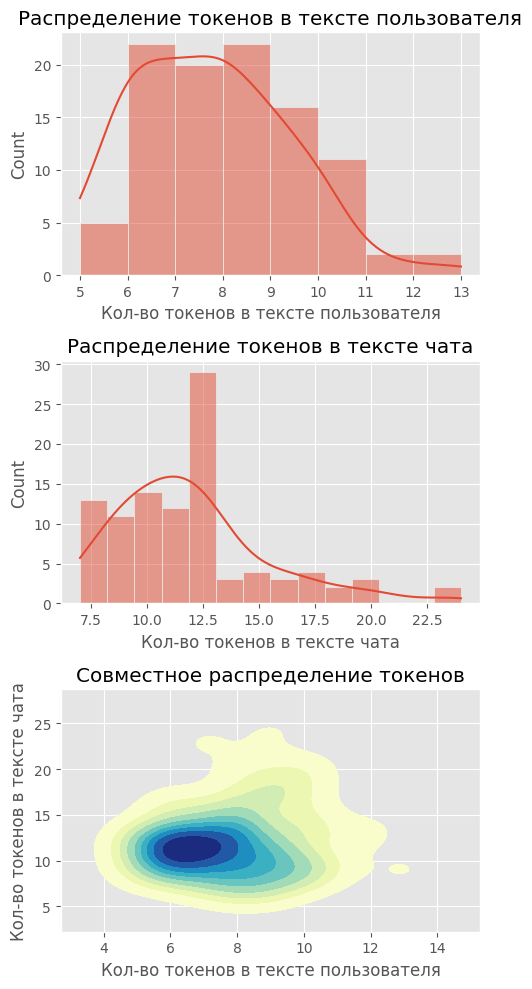

In [4]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))  # Три строки, один столбец

sns.set_palette('Set2')

# Гистограмма и график плотности для количества токенов в тексте пользователя
sns.histplot(x='Кол-во токенов в тексте пользователя', data=df, kde=True, ax=ax[0])
ax[0].set_title('Распределение токенов в тексте пользователя')

# Гистограмма и график плотности для количества токенов в тексте чата
sns.histplot(x='Кол-во токенов в тексте чата', data=df, kde=True, ax=ax[1])
ax[1].set_title('Распределение токенов в тексте чата')

# График плотности для совместного распределения количества токенов
sns.kdeplot(x='Кол-во токенов в тексте пользователя', y='Кол-во токенов в тексте чата', data=df, cmap='YlGnBu', fill=True, ax=ax[2])
ax[2].set_title('Совместное распределение токенов')

plt.tight_layout()  # Чтобы избежать перекрытия графиков
plt.show()

### Выполним очистку текста и преобразование данных

In [5]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['Кол-во токенов в тексте чата','Кол-во токенов в тексте пользователя'], axis=1, inplace=True)

df['Encoder_inputs'] = df['Пользователь'].apply(clean_text) #Вопросы пользователя, подготовленные для подачи в кодировщик
df['Decoder_targets'] = df['Чат'].apply(clean_text) + ' <end>' #Ответы чата, подготовленные для подачи в декодер, с добавлением метки <end> в конце каждого ответа
df['Decoder_inputs']='<start> '+ df['Чат'].apply(clean_text) + ' <end>' #Ответы чата, подготовленные для подачи в декодер, с добавлением меток <start> и <end> в начале и конце каждого ответа

df.head(10)

Пользователь  \
0                            Как открыть счет в ВТБ?   
1       Могу ли я открыть сберегательный счет в ВТБ?   
2      Какие документы мне нужны для открытия счета?   
3  Есть ли минимальный баланс на сберегательном с...   
4                  Какие виды счетов предлагает ВТБ?   
5  Могу ли я управлять счетом через интернет-банк...   
6           Какие преимущества открытия счета в ВТБ?   
7   Могу ли я открыть счет в ВТБ для своей компании?   
8  Какие услуги предоставляются в интернет-банкин...   
9  Какие дополнительные документы нужны для откры...   

                                                 Чат  \
0  Для открытия счета в ВТБ, посетите ближайшее о...   
1  Да, в ВТБ вы можете открыть сберегательный сче...   
2  Для открытия счета вам понадобятся паспорт и ИНН.   
3  Некоторые сберегательные счета могут не требов...   
4  ВТБ предлагает текущие счета, сберегательные с...   
5  Да, в ВТБ есть услуга интернет-банкинга для уп...   
6  Преимущества включают широкий выбор счетов, уд...   
7  Да, ВТБ предоставляет услуги корпоративного ба...   
8  В интернет-банкинге ВТБ вы можете проводить оп...   
9  Иностранные граждане могут потребовать дополни...   

                                      Encoder_inputs  \
0                          как открыть счет в втб ?    
1     могу ли я открыть сберегательный счет в втб ?    
2    какие документы мне нужны для открытия счета ?    
3  есть ли минимальный баланс на сберегательном с...   
4                какие виды счетов предлагает втб ?    
5  могу ли я управлять счетом через интернет банк...   
6         какие преимущества открытия счета в втб ?    
7  могу ли я открыть счет в втб для своей компани...   
8  какие услуги предоставляются в интернет банкин...   
9  какие дополнительные документы нужны для откры...   

                                     Decoder_targets  \
0  для открытия счета в втб ,  посетите ближайшее...   
1  да ,  в втб вы можете открыть сберегательный с...   
2  для открытия счета вам понадобятся паспорт и и...   
3  некоторые сберегательные счета могут не требов...   
4  втб предлагает текущие счета ,  сберегательные...   
5  да ,  в втб есть услуга интернет банкинга для ...   
6  преимущества включают широкий выбор счетов ,  ...   
7  да ,  втб предоставляет услуги корпоративного ...   
8  в интернет банкинге втб вы можете проводить оп...   
9  иностранные граждане могут потребовать дополни...   

                                      Decoder_inputs  
0  <start> для открытия счета в втб ,  посетите б...  
1  <start> да ,  в втб вы можете открыть сберегат...  
2  <start> для открытия счета вам понадобятся пас...  
3  <start> некоторые сберегательные счета могут н...  
4  <start> втб предлагает текущие счета ,  сберег...  
5  <start> да ,  в втб есть услуга интернет банки...  
6  <start> преимущества включают широкий выбор сч...  
7  <start> да ,  втб предоставляет услуги корпора...  
8  <start> в интернет банкинге втб вы можете пров...  
9  <start> иностранные граждане могут потребовать...

### Cоздаём новые столбцы в DataFrame df для отслеживания количества токенов (слов или символов) в каждом элементе столбцов

In [6]:
df['Encoder input tokens']=df['Encoder_inputs'].apply(lambda x:len(x.split())) #считаем количество токенов, которые представляют входные запросы пользователя
df['Decoder input tokens']=df['Decoder_inputs'].apply(lambda x:len(x.split())) #считает количество токенов, которые представляют входные данные для декодера
df['Decoder target tokens']=df['Decoder_targets'].apply(lambda x:len(x.split())) #считаем количество токенов, которые представляют целевые ответы декодера

### Визуализация распределения количества токенов

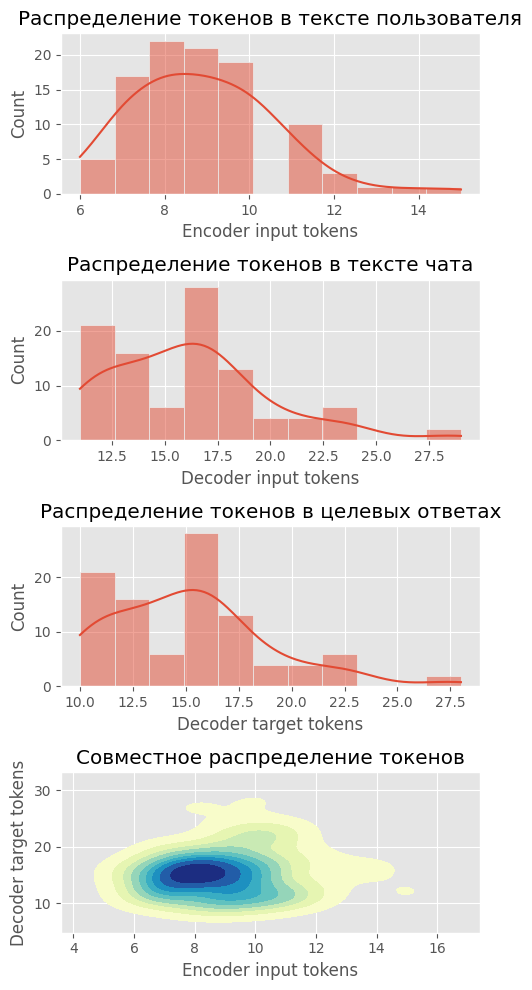

In [7]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5, 10))  # Три строки, один столбец

sns.set_palette('Set2')

# Гистограмма и график плотности для количества токенов в тексте пользователя
sns.histplot(x=df['Encoder input tokens'], data=df, kde=True, ax=ax[0])
ax[0].set_title('Распределение токенов в тексте пользователя')

# Гистограмма и график плотности для количества токенов в тексте чата
sns.histplot(x=df['Decoder input tokens'], data=df, kde=True, ax=ax[1])
ax[1].set_title('Распределение токенов в тексте чата')

# Гистограмма и график плотности для количества токенов в целевых ответах
sns.histplot(x=df['Decoder target tokens'], data=df, kde=True, ax=ax[2])
ax[2].set_title('Распределение токенов в целевых ответах')

# График плотности для совместного распределения количества токенов
sns.kdeplot(x='Encoder input tokens',y='Decoder target tokens', data=df, cmap='YlGnBu', fill=True, ax=ax[3])
ax[3].set_title('Совместное распределение токенов')

plt.tight_layout()  # Чтобы избежать перекрытия графиков
plt.show()


### Выводим информацию о данных после предварительной обработки, максимальных длинах входных и целевых данных, а также задает параметры модели и удаляет ненужные столбцы из DataFrame

In [8]:
# Вывод предложений с максимальной длиной после предварительной обработки
print(f"После предварительной обработки: {' '.join(df[df['Encoder input tokens'].max() == df['Encoder input tokens']]['Encoder_inputs'].values.tolist())}")

# Вывод максимальной длины для входных данных кодировщика
print(f"Максимальная длина входного сигнала энкодера: {df['Encoder input tokens'].max()}")

# Вывод максимальной длины для входных данных декодера
print(f"Максимальная длина входного сигнала декодера: {df['Decoder input tokens'].max()}")

# Вывод максимальной длины для целевых данных декодера
print(f"Максимальная целевая длина декодера: {df['Decoder target tokens'].max()}")

# Удаляем ненужные столбцы из DataFrame
df.drop(columns=['Пользователь', 'Чат', 'Encoder input tokens', 'Decoder input tokens', 'Decoder target tokens'], axis=1, inplace=True)

# Задаем параметры модели
params = {
    "vocab_size": 2500,
    "max_sequence_length": 30,
    "learning_rate": 0.008,
    "batch_size": 149,
    "lstm_cells": 256,
    "embedding_dim": 256,
    "buffer_size": 10000
}

# Извлекаем параметры из словаря
learning_rate = params['learning_rate']
batch_size = params['batch_size']
embedding_dim = params['embedding_dim']
lstm_cells = params['lstm_cells']
vocab_size = params['vocab_size']
buffer_size = params['buffer_size']
max_sequence_length = params['max_sequence_length']

# Выводим первые 10 строк DataFrame
df.head(10)


После предварительной обработки: могу ли я открыть счет в втб ,  если я не являюсь гражданином россии ? 
Максимальная длина входного сигнала энкодера: 15
Максимальная длина входного сигнала декодера: 29
Максимальная целевая длина декодера: 28


Encoder_inputs  \
0                          как открыть счет в втб ?    
1     могу ли я открыть сберегательный счет в втб ?    
2    какие документы мне нужны для открытия счета ?    
3  есть ли минимальный баланс на сберегательном с...   
4                какие виды счетов предлагает втб ?    
5  могу ли я управлять счетом через интернет банк...   
6         какие преимущества открытия счета в втб ?    
7  могу ли я открыть счет в втб для своей компани...   
8  какие услуги предоставляются в интернет банкин...   
9  какие дополнительные документы нужны для откры...   

                                     Decoder_targets  \
0  для открытия счета в втб ,  посетите ближайшее...   
1  да ,  в втб вы можете открыть сберегательный с...   
2  для открытия счета вам понадобятся паспорт и и...   
3  некоторые сберегательные счета могут не требов...   
4  втб предлагает текущие счета ,  сберегательные...   
5  да ,  в втб есть услуга интернет банкинга для ...   
6  преимущества включают широкий выбор счетов ,  ...   
7  да ,  втб предоставляет услуги корпоративного ...   
8  в интернет банкинге втб вы можете проводить оп...   
9  иностранные граждане могут потребовать дополни...   

                                      Decoder_inputs  
0  <start> для открытия счета в втб ,  посетите б...  
1  <start> да ,  в втб вы можете открыть сберегат...  
2  <start> для открытия счета вам понадобятся пас...  
3  <start> некоторые сберегательные счета могут н...  
4  <start> втб предлагает текущие счета ,  сберег...  
5  <start> да ,  в втб есть услуга интернет банки...  
6  <start> преимущества включают широкий выбор сч...  
7  <start> да ,  втб предоставляет услуги корпора...  
8  <start> в интернет банкинге втб вы можете пров...  
9  <start> иностранные граждане могут потребовать...

### Векторизация текстовых данных

In [9]:
# Создаем слой для векторизации текста
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,  # Максимальное количество токенов в словаре
    standardize=None,  # Не выполняем стандартизацию текста
    output_mode='int',  # Выводим целочисленные значения для токенов
    output_sequence_length=max_sequence_length  # Максимальная длина последовательности
)

# Обучаем слой на текстовых данных
vectorize_layer.adapt(df['Encoder_inputs'] + ' ' + df['Decoder_targets'] + ' <start> <end>')

# Получаем размер словаря после адаптации
vocab_size = len(vectorize_layer.get_vocabulary())
print(f'Размер словаря: {len(vectorize_layer.get_vocabulary())}')

# Выводим первые 12 токенов из словаря
print(f'{vectorize_layer.get_vocabulary()[:12]}')


Размер словаря: 377
['', '[UNK]', '<end>', 'втб', 'в', '.', '?', '<start>', ',', 'счета', 'для', 'и']


### Выполняем взаимное преобразование текстовых последовательностей и их числовых представлений

In [10]:
# Функция для преобразования текстовой последовательности в числовое представление
def sequences2ids(sequence):
    return vectorize_layer(sequence)

# Функция для преобразования числового представления в текстовую последовательность
def ids2sequences(ids):
    decode = ''
    if type(ids) == int:
        ids = [ids]
    for id in ids:
        decode += vectorize_layer.get_vocabulary()[id] + ' '
    return decode

# Преобразуем текстовые данные в числовые представления
x = sequences2ids(df['Encoder_inputs'])
yd = sequences2ids(df['Decoder_inputs'])
y = sequences2ids(df['Decoder_targets'])

# Выводим информацию о данных
print(f'Исходное предложение: Как открыть счет в ВТБ ?')
print(f'Последовательность токенов: {sequences2ids("Как открыть счет в ВТБ ?")[:10]}')
print(f'Форма входных данных для кодировщика: {x.shape}')
print(f'Форма входных данных для декодера: {yd.shape}')
print(f'Форма целевых данных для декодера: {y.shape}')


Исходное предложение: Как открыть счет в ВТБ ?
Последовательность токенов: [ 1 29 24  4  1  6  0  0  0  0]
Форма входных данных для кодировщика: (100, 30)
Форма входных данных для декодера: (100, 30)
Форма целевых данных для декодера: (100, 30)


In [11]:
# Вывод первых 12 элементов числового представления входных данных для кодировщика
print(f'Входной текст для кодировщика: {x[0][:12]} ...')

# Вывод первых 12 элементов числового представления входных данных для декодера.
# Входные данные для декодера сдвинуты на один временной шаг по отношению к цели,
# так как входом в декодер является вывод предыдущего временного шага.
print(f'Входные данные для декодера: {yd[0][:12]} ...')

# Вывод первых 12 элементов числового представления целевых данных для декодера
print(f'Целевые данные для декодера: {y[0][:12]} ...')


Входной текст для кодировщика: [34 29 24  4  3  6  0  0  0  0  0  0] ...
Входные данные для декодера: [  7  10  16   9   4   3   8 120 180 126  77  19] ...
Целевые данные для декодера: [ 10  16   9   4   3   8 120 180 126  77  19 124] ...


### Подготовка и обработка данных для обучения и проверки модели, а также вывод информации о размерах данных и формах входов и выходов

In [12]:
# Создание tf.data.Dataset из тензоров x, yd и y
data = tf.data.Dataset.from_tensor_slices((x, yd, y))

# Перемешивание данных с заданным размером буфера
data = data.shuffle(buffer_size)

# Разделение данных на обучающий и проверочный наборы
train_data = data.take(int(.9 * len(data)))
train_data = train_data.cache()  # Кеширование данных для ускорения обучения
train_data = train_data.shuffle(buffer_size)  # Перемешивание данных в обучающем наборе
train_data = train_data.batch(batch_size)  # Разделение данных на пакеты заданного размера
train_data = train_data.prefetch(tf.data.AUTOTUNE)  # Подгрузка данных во время обучения (автоматическое определение оптимального уровня)

# Создание итератора для обучающего набора данных
train_data_iterator = train_data.as_numpy_iterator()

# Определение количества пакетов в обучающем и проверочном наборах
print(f'Количество пакетов в обучающем наборе: {len(train_data)}')
print(f'Количество данных в обучающем наборе: {len(train_data) * batch_size}')

val_data = data.skip(int(.9 * len(data))).take(int(.1 * len(data)))  # Подготовка данных для проверочного набора
val_data = val_data.batch(batch_size)  # Разделение данных в проверочном наборе на пакеты
val_data = val_data.prefetch(tf.data.AUTOTUNE)  # Подгрузка данных во время проверки (автоматическое определение оптимального уровня)

# Получение информации о форме данных
_=train_data_iterator.next()
print(f'Форма входных данных для кодировщика (с учетом пакетов): {_[0].shape}')
print(f'Форма входных данных для декодера (с учетом пакетов): {_[1].shape}')
print(f'Форма целевых данных (с учетом пакетов): {_[2].shape}')


Количество пакетов в обучающем наборе: 1
Количество данных в обучающем наборе: 149
Форма входных данных для кодировщика (с учетом пакетов): (90, 30)
Форма входных данных для декодера (с учетом пакетов): (90, 30)
Форма целевых данных (с учетом пакетов): (90, 30)


### Cоздаём класс Encoder, который представляет кодировщик в модели Seq2Seq. Кодировщик использует слой встраивания (Embedding) для преобразования входных данных в векторы встраивания. Затем применяются слои нормализации, дропаута и LSTM для кодирования входных данных и получения состояния кодировщика

In [13]:
# Класс Encoder, который представляет собой кодировщик модели Seq2Seq
class Encoder(tf.keras.models.Model):
    def __init__(self, units, embedding_dim, vocab_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.units = units  # Количество юнитов LSTM в кодировщике
        self.vocab_size = vocab_size  # Размер словаря (vocab_size) для встраивания
        self.embedding_dim = embedding_dim  # Размерность встраивания
        self.embedding = Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,  # Маскирование нулевых значений (паддингов)
            embeddings_initializer=tf.keras.initializers.GlorotNormal()  # Инициализация весов встраивания
        )
        self.normalize = LayerNormalization()  # Слой нормализации
        self.lstm = LSTM(
            units,
            dropout=0.4,  # Вероятность дропаута для предотвращения переобучения
            return_state=True,  # Возвращение состояния LSTM
            return_sequences=True,  # Возвращение последовательности вывода
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()  # Инициализация весов LSTM
        )

    def call(self, encoder_inputs):
        self.inputs = encoder_inputs  # Входные данные для кодировщика
        x = self.embedding(encoder_inputs)  # Применение слоя встраивания к входным данным
        x = self.normalize(x)  # Применение нормализации
        x = Dropout(0.4)(x)  # Применение дропаута
        encoder_outputs, encoder_state_h, encoder_state_c = self.lstm(x)  # Передача данных через LSTM
        self.outputs = [encoder_state_h, encoder_state_c]  # Запоминание состояния кодировщика
        return encoder_state_h, encoder_state_c  # Возвращение состояния кодировщика

# Создание экземпляра кодировщика
encoder = Encoder(lstm_cells, embedding_dim, vocab_size, name='encoder')
encoder.call(_[0])  # Вызов метода call с входными данными


(<tf.Tensor: shape=(90, 256), dtype=float32, numpy=
 array([[-0.10507372,  0.2585821 , -0.02391972, ..., -0.29476374,
          0.22077541,  0.3397464 ],
        [-0.05349133,  0.12743062, -0.02596525, ..., -0.4217752 ,
          0.09155014,  0.03893045],
        [ 0.0711576 ,  0.20692801, -0.01192549, ..., -0.29519024,
          0.2837428 ,  0.1304937 ],
        ...,
        [-0.05091136,  0.16852674, -0.03871805, ..., -0.44384632,
          0.10086848,  0.06907788],
        [-0.0090976 ,  0.20221259,  0.12787648, ..., -0.38912687,
          0.07808776, -0.33142483],
        [ 0.11181138,  0.19004968, -0.00865146, ..., -0.36219877,
          0.1429054 , -0.0789907 ]], dtype=float32)>,
 <tf.Tensor: shape=(90, 256), dtype=float32, numpy=
 array([[-0.30707148,  0.5390711 , -0.08127051, ..., -0.5480042 ,
          0.42022908,  0.58826154],
        [-0.15012679,  0.2565275 , -0.08815356, ..., -0.8840383 ,
          0.15210055,  0.05812513],
        [ 0.19927593,  0.4266947 , -0.04067714, .

### Cоздаём класс Decoder, который представляет декодер в модели Seq2Seq. Декодер использует слой встраивания (Embedding) для преобразования входных данных декодера в векторы встраивания. Затем применяются слои нормализации, дропаута и LSTM для декодирования входных данных с использованием состояния кодировщика и получения предсказанных выходных данных с функцией активации softmax

In [14]:
# Класс Decoder, представляющий декодер модели Seq2Seq
class Decoder(tf.keras.models.Model):
    def __init__(self, units, embedding_dim, vocab_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.units = units  # Количество юнитов LSTM в декодере
        self.embedding_dim = embedding_dim  # Размерность встраивания
        self.vocab_size = vocab_size  # Размер словаря (vocab_size) для встраивания
        self.embedding = Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,  # Маскирование нулевых значений (паддингов)
            embeddings_initializer=tf.keras.initializers.HeNormal()  # Инициализация весов встраивания
        )
        self.normalize = LayerNormalization()  # Слой нормализации
        self.lstm = LSTM(
            units,
            dropout=0.4,  # Вероятность дропаута для предотвращения переобучения
            return_state=True,  # Возвращение состояния LSTM
            return_sequences=True,  # Возвращение последовательности вывода
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()  # Инициализация весов LSTM
        )
        self.fc = Dense(
            vocab_size,
            activation='softmax',  # Функция активации для выходного слоя
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()  # Инициализация весов для выходного слоя
        )

    def call(self, decoder_inputs, encoder_states):
        x = self.embedding(decoder_inputs)  # Применение слоя встраивания к входным данным декодера
        x = self.normalize(x)  # Применение нормализации
        x = Dropout(0.4)(x)  # Применение дропаута
        x, decoder_state_h, decoder_state_c = self.lstm(x, initial_state=encoder_states)  # Передача данных через LSTM
        x = self.normalize(x)  # Применение нормализации
        x = Dropout(0.4)(x)  # Применение дропаута
        return self.fc(x)  # Применение выходного слоя Dense с функцией активации softmax

# Создание экземпляра декодера
decoder = Decoder(lstm_cells, embedding_dim, vocab_size, name='decoder')
decoder(_[1][:1], encoder(_[0][:1]))  # Вызов метода call с входными данными декодера и состоянием кодировщика

<tf.Tensor: shape=(1, 30, 377), dtype=float32, numpy=
array([[[1.4338300e-03, 3.1977548e-04, 1.5888043e-03, ...,
         1.5311108e-04, 6.7544663e-03, 1.1055928e-03],
        [7.6126854e-04, 2.7240530e-04, 7.1195752e-04, ...,
         4.6564597e-05, 2.1391183e-02, 4.1553667e-03],
        [1.1751364e-03, 3.2048940e-04, 2.5969208e-03, ...,
         2.6785592e-03, 9.0562748e-03, 1.0542536e-04],
        ...,
        [1.4566176e-03, 7.2084664e-04, 1.0935676e-03, ...,
         3.2001533e-04, 4.1316096e-03, 3.2146752e-03],
        [1.4566174e-03, 7.2084652e-04, 1.0935677e-03, ...,
         3.2001530e-04, 4.1316091e-03, 3.2146762e-03],
        [1.4566174e-03, 7.2084652e-04, 1.0935677e-03, ...,
         3.2001530e-04, 4.1316091e-03, 3.2146762e-03]]], dtype=float32)>

### Напишем класс ChatBotTrainer, который отвечает за обучение модели чат-бота. Класс содержит методы для вычисления функции потерь и точности, а также для выполнения прямого итерации обучения и тестирования модели

In [15]:
# Класс ChatBotTrainer, отвечающий за обучение модели чат-бота
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self, encoder, decoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder  # Экземпляр класса Encoder, представляющего кодировщик
        self.decoder = decoder  # Экземпляр класса Decoder, представляющего декодер

    # Метод для вычисления функции потерь
    def loss_fn(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)  # Рассчет функции потерь
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))  # Создание маски для игнорирования паддингов
        mask = tf.cast(mask, dtype=loss.dtype)  # Преобразование маски в тип функции потерь
        loss *= mask  # Применение маски к функции потерь
        return tf.reduce_mean(loss)  # Возвращение усредненной функции потерь

    # Метод для вычисления точности модели
    def accuracy_fn(self, y_true, y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')  # Получение предсказанных значений
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')  # Подсчет правильных предсказаний
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')  # Создание маски для игнорирования паддингов
        n_correct = tf.keras.backend.sum(mask * correct)  # Подсчет правильных предсказаний
        n_total = tf.keras.backend.sum(mask)  # Подсчет общего количества примеров
        return n_correct / n_total  # Возвращение точности

    # Метод для выполнения прямого прохода модели
    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs  # Разделение входных данных на входы кодировщика и декодера
        encoder_states = self.encoder(encoder_inputs)  # Получение состояния кодировщика
        return self.decoder(decoder_inputs, encoder_states)  # Выполнение декодирования

    # Метод для выполнения одной итерации обучения
    def train_step(self, batch):
        encoder_inputs, decoder_inputs, y = batch  # Разделение пакета на входы кодировщика, входы декодера и целевые значения
        with tf.GradientTape() as tape:
            encoder_states = self.encoder(encoder_inputs, training=True)  # Получение состояния кодировщика
            y_pred = self.decoder(decoder_inputs, encoder_states, training=True)  # Получение предсказанных значений
            loss = self.loss_fn(y, y_pred)  # Вычисление функции потерь
            acc = self.accuracy_fn(y, y_pred)  # Вычисление точности

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables  # Получение обучаемых переменных
        grads = tape.gradient(loss, variables)  # Вычисление градиентов
        self.optimizer.apply_gradients(zip(grads, variables))  # Применение градиентов для обновления весов
        metrics = {'loss': loss, 'accuracy': acc}  # Сбор метрик
        return metrics  # Возвращение метрик

    # Метод для выполнения одной итерации тестирования
    def test_step(self, batch):
        encoder_inputs, decoder_inputs, y = batch  # Разделение пакета на входы кодировщика, входы декодера и целевые значения
        encoder_states = self.encoder(encoder_inputs, training=True)  # Получение состояния кодировщика
        y_pred = self.decoder(decoder_inputs, encoder_states, training=True)  # Получение предсказанных значений
        loss = self.loss_fn(y, y_pred)  # Вычисление функции потерь
        acc = self.accuracy_fn(y, y_pred)  # Вычисление точности
        metrics = {'loss': loss, 'accuracy': acc}  # Сбор метрик
        return metrics  # Возвращение метрик


In [16]:
# Создание экземпляра класса ChatBotTrainer, который будет отвечать за обучение модели чат-бота
model = ChatBotTrainer(encoder, decoder, name='chatbot_trainer')

# Компиляция модели с определением функции потерь, оптимизатора и метрик
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Функция потерь Sparse Categorical Crossentropy
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Оптимизатор Adam с заданной скоростью обучения
    weighted_metrics=['loss', 'accuracy']  # Метрики - функция потерь и точность
)

# Выполнение прямого прохода модели на первых двух пакетах данных для проверки
model(_[:2])

<tf.Tensor: shape=(90, 30, 377), dtype=float32, numpy=
array([[[1.43382838e-03, 3.19775252e-04, 1.58880407e-03, ...,
         1.53110974e-04, 6.75446307e-03, 1.10559235e-03],
        [7.61268544e-04, 2.72405014e-04, 7.11957517e-04, ...,
         4.65645971e-05, 2.13911887e-02, 4.15536482e-03],
        [1.17513631e-03, 3.20489140e-04, 2.59692082e-03, ...,
         2.67855707e-03, 9.05627944e-03, 1.05425323e-04],
        ...,
        [1.45661645e-03, 7.20846932e-04, 1.09356781e-03, ...,
         3.20015301e-04, 4.13161330e-03, 3.21467337e-03],
        [1.45661645e-03, 7.20846932e-04, 1.09356781e-03, ...,
         3.20015301e-04, 4.13161330e-03, 3.21467337e-03],
        [1.45661645e-03, 7.20846932e-04, 1.09356781e-03, ...,
         3.20015301e-04, 4.13161330e-03, 3.21467337e-03]],

       [[6.49645051e-04, 1.69516599e-04, 1.16923987e-03, ...,
         3.86074913e-04, 5.33126714e-03, 1.84164348e-03],
        [4.36520844e-04, 2.59445893e-04, 4.41621582e-04, ...,
         8.12473954e-05, 2.2

### Обучаем модель

In [17]:
# Обучение модели с использованием метода fit
Training = model.fit(
    train_data,  # Данные для обучения
    epochs=100,  # Количество эпох обучения
    validation_data=val_data,  # Данные для валидации
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),  # Ведение логов для TensorBoard
        tf.keras.callbacks.ModelCheckpoint('chatbot', verbose=1, save_best_only=True)  # Сохранение модели при улучшении
    ]
)

Epoch 1/100


1/1 [==============================] - ETA: 0s - loss: 3.7540 - accuracy: 0.0044
Epoch 1: val_loss improved from inf to 2.71251, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 76s 76s/step - loss: 3.7540 - accuracy: 0.0044 - val_loss: 2.7125 - val_accuracy: 0.0946
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 2.8596 - accuracy: 0.0776
Epoch 2: val_loss improved from 2.71251 to 2.01667, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 53s 53s/step - loss: 2.8596 - accuracy: 0.0776 - val_loss: 2.0167 - val_accuracy: 0.1739
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 2.3425 - accuracy: 0.1515
Epoch 3: val_loss improved from 2.01667 to 1.63207, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 54s 54s/step - loss: 2.3425 - accuracy: 0.1515 - val_loss: 1.6321 - val_accuracy: 0.2681
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.9667 - accuracy: 0.2225
Epoch 4: val_loss improved from 1.63207 to 1.46090, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 56s 56s/step - loss: 1.9667 - accuracy: 0.2225 - val_loss: 1.4609 - val_accuracy: 0.2993
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 1.7051 - accuracy: 0.3089
Epoch 5: val_loss improved from 1.46090 to 1.38975, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 61s 61s/step - loss: 1.7051 - accuracy: 0.3089 - val_loss: 1.3898 - val_accuracy: 0.3630
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 1.5214 - accuracy: 0.3732
Epoch 6: val_loss improved from 1.38975 to 1.30715, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 53s 53s/step - loss: 1.5214 - accuracy: 0.3732 - val_loss: 1.3072 - val_accuracy: 0.4771
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 1.2901 - accuracy: 0.4346
Epoch 7: val_loss improved from 1.30715 to 1.03798, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 50s 50s/step - loss: 1.2901 - accuracy: 0.4346 - val_loss: 1.0380 - val_accuracy: 0.4965
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 1.1522 - accuracy: 0.4893
Epoch 8: val_loss did not improve from 1.03798
1/1 [==============================] - 3s 3s/step - loss: 1.1522 - accuracy: 0.4893 - val_loss: 1.1875 - val_accuracy: 0.4730
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 1.0256 - accuracy: 0.5336
Epoch 9: val_loss did not improve from 1.03798
1/1 [==============================] - 3s 3s/step - loss: 1.0256 - accuracy: 0.5336 - val_loss: 1.1614 - val_accuracy: 0.5407
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.9108 - accuracy: 0.5839
Epoch 10: val_loss improved from 1.03798 to 0.69291, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 55s 55s/step - loss: 0.9108 - accuracy: 0.5839 - val_loss: 0.6929 - val_accuracy: 0.6516
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.8359 - accuracy: 0.5942
Epoch 11: val_loss did not improve from 0.69291
1/1 [==============================] - 3s 3s/step - loss: 0.8359 - accuracy: 0.5942 - val_loss: 0.8924 - val_accuracy: 0.6125
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6415
Epoch 12: val_loss did not improve from 0.69291
1/1 [==============================] - 3s 3s/step - loss: 0.7315 - accuracy: 0.6415 - val_loss: 0.9290 - val_accuracy: 0.5912
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.6497
Epoch 13: val_loss improved from 0.69291 to 0.52467, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 56s 56s/step - loss: 0.6729 - accuracy: 0.6497 - val_loss: 0.5247 - val_accuracy: 0.7358
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.6837
Epoch 14: val_loss improved from 0.52467 to 0.51245, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 52s 52s/step - loss: 0.5987 - accuracy: 0.6837 - val_loss: 0.5125 - val_accuracy: 0.7485
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.6992
Epoch 15: val_loss did not improve from 0.51245
1/1 [==============================] - 4s 4s/step - loss: 0.5641 - accuracy: 0.6992 - val_loss: 0.5229 - val_accuracy: 0.7811
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.7288
Epoch 16: val_loss did not improve from 0.51245
1/1 [==============================] - 4s 4s/step - loss: 0.5143 - accuracy: 0.7288 - val_loss: 0.6735 - val_accuracy: 0.6667
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.7554
Epoch 17: val_loss did not improve from 0.51245
1/1 [==============================] - 4s 4s/step - loss: 0.4551 - accuracy: 0.7554 - val_loss: 0.5533 - val_accuracy: 0.7099
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 53s 53s/step - loss: 0.4410 - accuracy: 0.7517 - val_loss: 0.4262 - val_accuracy: 0.7619
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.7716
Epoch 19: val_loss improved from 0.42624 to 0.26654, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 60s 60s/step - loss: 0.3899 - accuracy: 0.7716 - val_loss: 0.2665 - val_accuracy: 0.9116
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.7908
Epoch 20: val_loss did not improve from 0.26654
1/1 [==============================] - 4s 4s/step - loss: 0.3524 - accuracy: 0.7908 - val_loss: 0.4365 - val_accuracy: 0.7922
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8174
Epoch 21: val_loss did not improve from 0.26654
1/1 [==============================] - 4s 4s/step - loss: 0.3189 - accuracy: 0.8174 - val_loss: 0.5784 - val_accuracy: 0.7455
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.8137
Epoch 22: val_loss improved from 0.26654 to 0.22528, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 53s 53s/step - loss: 0.3129 - accuracy: 0.8137 - val_loss: 0.2253 - val_accuracy: 0.8834
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8285
Epoch 23: val_loss did not improve from 0.22528
1/1 [==============================] - 4s 4s/step - loss: 0.2821 - accuracy: 0.8285 - val_loss: 0.3808 - val_accuracy: 0.8253
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.8367
Epoch 24: val_loss did not improve from 0.22528
1/1 [==============================] - 4s 4s/step - loss: 0.2575 - accuracy: 0.8367 - val_loss: 0.3546 - val_accuracy: 0.7895
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.8411
Epoch 25: val_loss did not improve from 0.22528
1/1 [==============================] - 4s 4s/step - loss: 0.2470 - accuracy: 0.8411 - val_loss: 0.2276 - val_accuracy: 0.8608
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 56s 56s/step - loss: 0.1998 - accuracy: 0.8655 - val_loss: 0.1928 - val_accuracy: 0.8679
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.8721
Epoch 29: val_loss did not improve from 0.19283
1/1 [==============================] - 3s 3s/step - loss: 0.1977 - accuracy: 0.8721 - val_loss: 0.2136 - val_accuracy: 0.8750
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.8840
Epoch 30: val_loss did not improve from 0.19283
1/1 [==============================] - 3s 3s/step - loss: 0.1861 - accuracy: 0.8840 - val_loss: 0.3769 - val_accuracy: 0.8408
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.8965
Epoch 31: val_loss did not improve from 0.19283
1/1 [==============================] - 3s 3s/step - loss: 0.1711 - accuracy: 0.8965 - val_loss: 0.2219 - val_accuracy: 0.8506
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 60s 60s/step - loss: 0.1751 - accuracy: 0.8862 - val_loss: 0.1425 - val_accuracy: 0.8987
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.8921
Epoch 33: val_loss did not improve from 0.14253
1/1 [==============================] - 3s 3s/step - loss: 0.1585 - accuracy: 0.8921 - val_loss: 0.1944 - val_accuracy: 0.8862
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9069
Epoch 34: val_loss did not improve from 0.14253
1/1 [==============================] - 3s 3s/step - loss: 0.1470 - accuracy: 0.9069 - val_loss: 0.2822 - val_accuracy: 0.8239
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.8973
Epoch 35: val_loss did not improve from 0.14253
1/1 [==============================] - 3s 3s/step - loss: 0.1524 - accuracy: 0.8973 - val_loss: 0.1582 - val_accuracy: 0.9205
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 53s 53s/step - loss: 0.1426 - accuracy: 0.9106 - val_loss: 0.1226 - val_accuracy: 0.9346
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9224
Epoch 37: val_loss did not improve from 0.12262
1/1 [==============================] - 4s 4s/step - loss: 0.1257 - accuracy: 0.9224 - val_loss: 0.1352 - val_accuracy: 0.9062
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.9113
Epoch 38: val_loss did not improve from 0.12262
1/1 [==============================] - 4s 4s/step - loss: 0.1304 - accuracy: 0.9113 - val_loss: 0.3314 - val_accuracy: 0.8581
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9261
Epoch 39: val_loss improved from 0.12262 to 0.10682, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 55s 55s/step - loss: 0.1212 - accuracy: 0.9261 - val_loss: 0.1068 - val_accuracy: 0.9200
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9320
Epoch 40: val_loss did not improve from 0.10682
1/1 [==============================] - 4s 4s/step - loss: 0.1057 - accuracy: 0.9320 - val_loss: 0.2303 - val_accuracy: 0.8896
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9217
Epoch 41: val_loss did not improve from 0.10682
1/1 [==============================] - 4s 4s/step - loss: 0.1106 - accuracy: 0.9217 - val_loss: 0.2045 - val_accuracy: 0.8947
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9239
Epoch 42: val_loss improved from 0.10682 to 0.08482, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 55s 55s/step - loss: 0.1061 - accuracy: 0.9239 - val_loss: 0.0848 - val_accuracy: 0.9542
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9246
Epoch 43: val_loss did not improve from 0.08482
1/1 [==============================] - 3s 3s/step - loss: 0.1075 - accuracy: 0.9246 - val_loss: 0.2106 - val_accuracy: 0.9152
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9305
Epoch 44: val_loss improved from 0.08482 to 0.07676, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 53s 53s/step - loss: 0.1015 - accuracy: 0.9305 - val_loss: 0.0768 - val_accuracy: 0.9514
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.9290
Epoch 45: val_loss did not improve from 0.07676
1/1 [==============================] - 4s 4s/step - loss: 0.1053 - accuracy: 0.9290 - val_loss: 0.1173 - val_accuracy: 0.9345
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9350
Epoch 46: val_loss did not improve from 0.07676
1/1 [==============================] - 4s 4s/step - loss: 0.0989 - accuracy: 0.9350 - val_loss: 0.1118 - val_accuracy: 0.9097
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9320
Epoch 47: val_loss did not improve from 0.07676
1/1 [==============================] - 4s 4s/step - loss: 0.0919 - accuracy: 0.9320 - val_loss: 0.1527 - val_accuracy: 0.9226
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 53s 53s/step - loss: 0.1014 - accuracy: 0.9268 - val_loss: 0.0668 - val_accuracy: 0.9592
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9453
Epoch 50: val_loss did not improve from 0.06675
1/1 [==============================] - 4s 4s/step - loss: 0.0896 - accuracy: 0.9453 - val_loss: 0.0864 - val_accuracy: 0.9504
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9438
Epoch 51: val_loss did not improve from 0.06675
1/1 [==============================] - 4s 4s/step - loss: 0.0811 - accuracy: 0.9438 - val_loss: 0.1255 - val_accuracy: 0.9172
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9490
Epoch 52: val_loss did not improve from 0.06675
1/1 [==============================] - 4s 4s/step - loss: 0.0771 - accuracy: 0.9490 - val_loss: 0.1204 - val_accuracy: 0.9157
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 56s 56s/step - loss: 0.0709 - accuracy: 0.9512 - val_loss: 0.0471 - val_accuracy: 0.9669
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9505
Epoch 56: val_loss did not improve from 0.04711
1/1 [==============================] - 5s 5s/step - loss: 0.0725 - accuracy: 0.9505 - val_loss: 0.0682 - val_accuracy: 0.9530
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9394
Epoch 57: val_loss did not improve from 0.04711
1/1 [==============================] - 5s 5s/step - loss: 0.0795 - accuracy: 0.9394 - val_loss: 0.1361 - val_accuracy: 0.9338
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9483
Epoch 58: val_loss did not improve from 0.04711
1/1 [==============================] - 5s 5s/step - loss: 0.0733 - accuracy: 0.9483 - val_loss: 0.0726 - val_accuracy: 0.9545
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 62s 62s/step - loss: 0.0561 - accuracy: 0.9653 - val_loss: 0.0451 - val_accuracy: 0.9660
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9704
Epoch 70: val_loss did not improve from 0.04511
1/1 [==============================] - 4s 4s/step - loss: 0.0481 - accuracy: 0.9704 - val_loss: 0.2029 - val_accuracy: 0.9077
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9534
Epoch 71: val_loss did not improve from 0.04511
1/1 [==============================] - 4s 4s/step - loss: 0.0579 - accuracy: 0.9534 - val_loss: 0.0846 - val_accuracy: 0.9375
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9675
Epoch 72: val_loss did not improve from 0.04511
1/1 [==============================] - 4s 4s/step - loss: 0.0467 - accuracy: 0.9675 - val_loss: 0.0870 - val_accuracy: 0.9752
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 62s 62s/step - loss: 0.0520 - accuracy: 0.9653 - val_loss: 0.0348 - val_accuracy: 0.9722
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9667
Epoch 76: val_loss improved from 0.03481 to 0.02805, saving model to chatbot


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 58s 58s/step - loss: 0.0502 - accuracy: 0.9667 - val_loss: 0.0281 - val_accuracy: 0.9863
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9734
Epoch 77: val_loss did not improve from 0.02805
1/1 [==============================] - 4s 4s/step - loss: 0.0457 - accuracy: 0.9734 - val_loss: 0.1128 - val_accuracy: 0.9565
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9667
Epoch 78: val_loss did not improve from 0.02805
1/1 [==============================] - 4s 4s/step - loss: 0.0520 - accuracy: 0.9667 - val_loss: 0.0445 - val_accuracy: 0.9645
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9712
Epoch 79: val_loss did not improve from 0.02805
1/1 [==============================] - 4s 4s/step - loss: 0.0424 - accuracy: 0.9712 - val_loss: 0.0637 - val_accuracy: 0.9557
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


1/1 [==============================] - 74s 74s/step - loss: 0.0467 - accuracy: 0.9660 - val_loss: 0.0206 - val_accuracy: 0.9931
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9749
Epoch 85: val_loss did not improve from 0.02059
1/1 [==============================] - 4s 4s/step - loss: 0.0406 - accuracy: 0.9749 - val_loss: 0.0831 - val_accuracy: 0.9565
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9734
Epoch 86: val_loss did not improve from 0.02059
1/1 [==============================] - 4s 4s/step - loss: 0.0362 - accuracy: 0.9734 - val_loss: 0.0525 - val_accuracy: 0.9712
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9697
Epoch 87: val_loss did not improve from 0.02059
1/1 [==============================] - 4s 4s/step - loss: 0.0430 - accuracy: 0.9697 - val_loss: 0.0295 - val_accuracy: 0.9773
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 

In [30]:
import tensorflow as tf

# Определите функцию потерь и другие пользовательские функции метрик, если они были использованы
custom_objects = {'loss': ChatBotTrainer.loss_fn}

# Загрузка модели с указанием пользовательских объектов
model = tf.keras.models.load_model('C:/Users/huawei/Downloads/ML Chat Bot/chatbot', custom_objects=custom_objects)


# Сохранение модели (если необходимо)
model.save('chatbot')


INFO:tensorflow:Assets written to: chatbot\assets


INFO:tensorflow:Assets written to: chatbot\assets


### Прходимся по всем слоям модели и выводим информацию о каждом из них

In [28]:
# Перебор слоев модели с индексами и вывод информации о каждом слое
for idx, i in enumerate(model.layers):
    # Вывод информации о слоях кодировщика и декодера, разделяя их
    print('Encoder layers:' if idx == 0 else 'Decoder layers: ')
    for j in i.layers:
        # Вывод отдельного слоя модели
        print(j)
    # Разделитель для лучшей читаемости
    print('---------------------')


Encoder layers:
---------------------
Decoder layers: 
---------------------


### Определяем модель чатбота и его методы для предобработки, постобработки и генерации ответов

In [29]:
# Класс ChatBot определяет модель чатбота и его методы для предобработки, постобработки и генерации ответов.
class ChatBot(tf.keras.models.Model):
    # Инициализация модели с базовым кодировщиком и декодировщиком
    def __init__(self, base_encoder, base_decoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder, self.decoder = self.build_inference_model(base_encoder, base_decoder)

    # Метод для построения модели вывода (inference model) на основе базовых кодировщика и декодировщика
    def build_inference_model(self, base_encoder, base_decoder):
        # Определение входов кодировщика
        encoder_inputs = tf.keras.Input(shape=(None,))
        x = base_encoder.layers[0](encoder_inputs)
        x = base_encoder.layers[1](x)
        x, encoder_state_h, encoder_state_c = base_encoder.layers[2](x)
        # Создание модели кодировщика
        encoder = tf.keras.models.Model(inputs=encoder_inputs, outputs=[encoder_state_h, encoder_state_c], name='chatbot_encoder')

        # Определение входов и состояний декодера
        decoder_input_state_h = tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c = tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs = tf.keras.Input(shape=(None,))
        x = base_decoder.layers[0](decoder_inputs)
        x = base_encoder.layers[1](x)
        x, decoder_state_h, decoder_state_c = base_decoder.layers[2](x, initial_state=[decoder_input_state_h, decoder_input_state_c])
        # Создание модели декодера
        decoder_outputs = base_decoder.layers[-1](x)
        decoder = tf.keras.models.Model(
            inputs=[decoder_inputs, [decoder_input_state_h, decoder_input_state_c]],
            outputs=[decoder_outputs, [decoder_state_h, decoder_state_c]], name='chatbot_decoder'
        )
        return encoder, decoder

    # Метод для вывода краткой информации о модели
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    # Метод для вычисления softmax вероятности
    def softmax(self, z):
        return np.exp(z) / sum(np.exp(z))

    # Метод для генерации ответа на основе вероятностей
    def sample(self, conditional_probability, temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    # Метод для предобработки текста
    def preprocess(self, text):
        text = clean_text(text)
        seq = np.zeros((1, max_sequence_length), dtype=np.int32)
        for i, word in enumerate(text.split()):
            seq[:, i] = sequences2ids(word).numpy()[0]
        return seq

    # Метод для постобработки текста
    def postprocess(self, text):
        text = re.sub(' - ', '-', text.lower())
        # Другие замены для обработки текста
        return text

    # Метод для генерации ответа на входной текст
    def call(self, text, config=None):
        input_seq = self.preprocess(text)
        states = self.encoder(input_seq, training=False)
        target_seq = np.zeros((1, 1))
        target_seq[:, :] = sequences2ids(['<start>']).numpy()[0][0]
        stop_condition = False
        decoded = []
        while not stop_condition:
            decoder_outputs, new_states = self.decoder([target_seq, states], training=False)
            index = self.sample(decoder_outputs[0, 0, :]).item()
            word = ids2sequences([index])
            if word == '<end> ' or len(decoded) >= max_sequence_length:
                stop_condition = True
            else:
                decoded.append(index)
                target_seq = np.zeros((1, 1))
                target_seq[:, :] = index
                states = new_states
        return self.postprocess(ids2sequences(decoded))

# Создание экземпляра чатбота
chatbot = ChatBot(model.encoder, model.decoder, name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        96512     
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 622,336
Trainable params: 622,336
Non

In [30]:
# Функция для печати диалога между пользователем и чатботом
def printOut(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('----------------------------')


In [36]:
printOut([
    # 'как открыть счет в ВТБ?',
    # 'как открыть счёт?',
    # 'могу ли я получить кредит на условиях открытия счета в ВТБ?',
    # 'могу ли я получить кредит?',
    # 'какие услуги оказывает ВТБ для корпоративных клиентов?',
    # 'какие услуги оказываются для корпоративных клиентов?',
    'Как часто я могу проверять баланс счета через интернет-банкинг',
    'проверка счёта через интернет'
])

You: Как часто я могу проверять баланс счета через интернет-банкинг
Bot: вы можете проверять баланс счета в интернет банкинге в любое время . 
----------------------------
You: проверка счёта через интернет
Bot: да , в втб есть услуга интернет банкинга для онлайн управления счетами . 
----------------------------
